In [1]:
import gym
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline

## Часть первая, с блекджеком и стратегиями

1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [2]:
env = gym.make('Blackjack-v0', natural=True)

In [3]:
def pi_naive(state):
    return state[0] < 19

def conduct_experiment(pi, n=100_000):
    rewards = []
    for _ in range(n):
        observation = env.reset()
        done = False
        reward = 0
        while not done:
            a = pi(observation)
            observation, reward, done, _ = env.step(a)
        rewards.append(reward)
    return rewards

def compute_confidence_interval(rewards, conf=0.95):
    mean = np.mean(rewards)
    std = st.sem(rewards)
    h = std * st.t.ppf((1 + conf) / 2., len(rewards)-1)
    return mean, mean - h, mean + h

In [4]:
n = 100000
rewards = conduct_experiment(pi_naive, n)
result, lower, upper = compute_confidence_interval(rewards)
print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {result},\n\
Доверительный интервал (95%): ({lower:0.4f}:{upper:0.4f})')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.180815,
Доверительный интервал (95%): (-0.1868:-0.1748)


2) Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [21]:
# Реализуем сразу метод с удвоением для 2-й части задания

from gym import spaces
from gym.utils import seeding
from gym.envs.toy_text.blackjack import BlackjackEnv

class BlackjackEnvWithDouble(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)  # Now we have 3 actions instead of 2 (stick=0, hit=1, double=2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add only one card, reward/loss is double.
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2.0 * cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 3.
            
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [5]:
# Q-Learner для стандартного env и с удвоением

class BlackJack_Q_Learner:
    def __init__(self, can_double = False, natural=True):
        self._ph = 32 # player_hand
        self._dh = 11 # dealer hand
        self._ua = 2 # usable ace
        self._nA = 3 if can_double else 2 # actions number
        self._nS = self._ph * self._dh * self._ua # nS
        if can_double:
            self._env = BlackjackEnvWithDouble(natural=natural)
        else:
            self._env = gym.make('Blackjack-v0', natural=natural)
    
    def _set_zero_Q(self):
        self._Q = np.zeros(shape=(self._nS, self._nA))
        
    def get_current_policy(self):
        return self._Q.argmax(1)
    
    def _observation_to_idx(self, s):
        return (s[0] - 1) * self._dh * self._ua + (s[1] - 1) * self._ua + s[2]
    
    def idx_to_observation(self, idx):
        s_2 = bool(idx % self._ua)
        idx = (idx - s_2) / self._ua
        s_1 = int(idx % self._dh + 1)
        s_0 = int((idx - (s_1 - 1)) / self._dh + 1)
        return (s_0, s_1, s_2)
    
    def _Q_learning_episode(self, alpha, epsilon, gamma):
        obs = self._env.reset()
        s = self._observation_to_idx(obs)
        pi = self.get_current_policy()
        if np.random.rand() > epsilon:
            a = pi[s]
        else:
            a = np.random.randint(self._nA)
        done = False
        while not done:
            pi = self.get_current_policy()
            observation, reward, done, _ = self._env.step(a)
            s_prime = self._observation_to_idx(observation)
            if np.random.rand() > epsilon:
                a_prime = pi[s_prime]
            else:
                a_prime = np.random.randint(self._nA)
            self._Q[s, a] = self._Q[s, a] + alpha * (reward + gamma * np.max(self._Q[s_prime]) - self._Q[s, a])
            s = s_prime
            if done:
                break
                
    def learn(self, alpha=3e-4, epsilon=0.4, gamma=1.0, n_episodes=100_000, print_every_k_episodes=None):
        self._set_zero_Q()
        pi = self.get_current_policy()
        mean_rewards = []
        l_bounds = []
        u_bounds = []
        for i in range(n_episodes):
            self._Q_learning_episode(alpha=alpha, epsilon=epsilon, gamma=gamma)
            pi = self.get_current_policy()
            if print_every_k_episodes and (i + 1) % print_every_k_episodes == 0:
                self.pi = pi
                rewards = self.conduct_experiment()
                mean_reward, lower, upper = compute_confidence_interval(rewards)
                print(f'Conducting experiment after {i + 1} episodes: {mean_reward}')
                mean_rewards.append(mean_reward)
                l_bounds.append(lower)
                u_bounds.append(upper)
        self.pi = pi
        if print_every_k_episodes:
            return mean_rewards, l_bounds, u_bounds
        
    def conduct_experiment(self, pi=None, n_experiments=200_000):
        if not pi:
            pi = self.pi
        rewards = []
        for _ in range(n_experiments):
            observation = self._env.reset()
            s = self._observation_to_idx(observation)
            done = False
            reward = 0
            while not done:
                a = pi[s]
                observation, reward, done, _ = self._env.step(a)
                s = self._observation_to_idx(observation)
            rewards.append(reward)
        return rewards

In [11]:
learner = BlackJack_Q_Learner(can_double=False)
learner.learn(n_episodes=100_000, alpha=1e-4, epsilon=0.2)
print("Learning complete!")
rewards = learner.conduct_experiment(n_experiments=200_000)
result, lower, upper = compute_confidence_interval(rewards)
print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {result},\n\
Доверительный интервал (95%): ({lower:0.4f}:{upper:0.4f})')

Learning complete!
Средний проигрыш при такой стратегии за 100000 экспериментов: -0.044735,
Доверительный интервал (95%): (-0.0491:-0.0404)


3) Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [16]:
total_episodes = 200_000
k = 10_000
alpha=1e-4
epsilon=0.2

learner = BlackJack_Q_Learner(can_double=False)
mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                 alpha=alpha, epsilon=epsilon,
                                                 print_every_k_episodes=k)
print("Learning complete!")

Conducting experiment after 10000 episodes: -0.06124
Conducting experiment after 20000 episodes: -0.060075
Conducting experiment after 30000 episodes: -0.0585175
Conducting experiment after 40000 episodes: -0.0483975
Conducting experiment after 50000 episodes: -0.0585
Conducting experiment after 60000 episodes: -0.0582325
Conducting experiment after 70000 episodes: -0.0549625
Conducting experiment after 80000 episodes: -0.05259
Conducting experiment after 90000 episodes: -0.059195
Conducting experiment after 100000 episodes: -0.0529625
Conducting experiment after 110000 episodes: -0.0456625
Conducting experiment after 120000 episodes: -0.0479125
Conducting experiment after 130000 episodes: -0.0530125
Conducting experiment after 140000 episodes: -0.0564475
Conducting experiment after 150000 episodes: -0.050585
Conducting experiment after 160000 episodes: -0.0584525
Conducting experiment after 170000 episodes: -0.05334
Conducting experiment after 180000 episodes: -0.04491
Conducting expe

Text(0.5, 1.0, 'Результат Q-обучения')

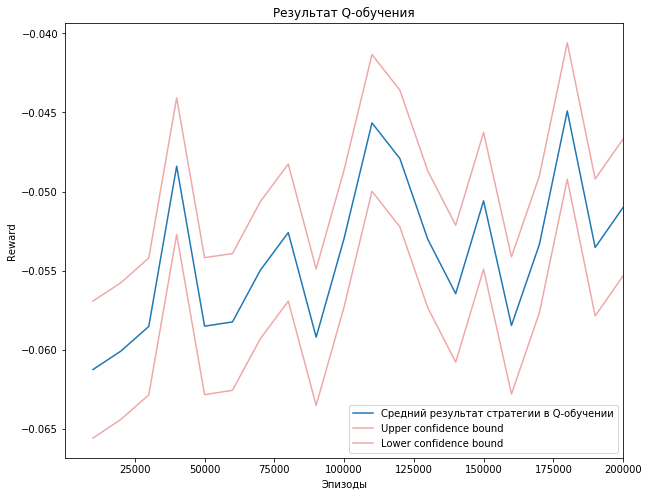

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

line_rewards = ax.plot(np.arange(k, total_episodes+1, k), mean_rewards, label="Средний результат стратегии в Q-обучении", color="C0")
line_upper = ax.plot(np.arange(k, total_episodes+1, k), u_bounds, label="Upper confidence bound", color="C3", alpha=0.4)
line_lower = ax.plot(np.arange(k, total_episodes+1, k), l_bounds, label="Lower confidence bound", color="C3", alpha=0.4)

lines = line_rewards + line_upper + line_lower
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="lower right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.title('Результат Q-обучения')

Видно, что в целом график идет вверх. Начало графика - после 10,000 эпизодов, иначе рост от первоначальной стратегии слишком большой и график становится не информативным.

Подберем параметры alpha и epsilon
Сначала epsilon

In [20]:
alpha = 1e-4
k=10_000
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_with_different_params = []
total_episodes = 200000
for eps in epsilons:
    print(f'Epsilon: {eps}')
    learner = BlackJack_Q_Learner(can_double=False)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=alpha, epsilon=eps,
                                                     print_every_k_episodes=k)
    results_with_different_params.append((mean_rewards, l_bounds, u_bounds))

Epsilon: 0.1
Conducting experiment after 10000 episodes: -0.06246
Conducting experiment after 20000 episodes: -0.058445
Conducting experiment after 30000 episodes: -0.0559975
Conducting experiment after 40000 episodes: -0.0556525
Conducting experiment after 50000 episodes: -0.053385
Conducting experiment after 60000 episodes: -0.05839
Conducting experiment after 70000 episodes: -0.06112
Conducting experiment after 80000 episodes: -0.059025
Conducting experiment after 90000 episodes: -0.0523075
Conducting experiment after 100000 episodes: -0.054965
Conducting experiment after 110000 episodes: -0.0574025
Conducting experiment after 120000 episodes: -0.0547025
Conducting experiment after 130000 episodes: -0.05193
Conducting experiment after 140000 episodes: -0.0422625
Conducting experiment after 150000 episodes: -0.0575675
Conducting experiment after 160000 episodes: -0.0501875
Conducting experiment after 170000 episodes: -0.054385
Conducting experiment after 180000 episodes: -0.046965
Co

Conducting experiment after 90000 episodes: -0.0462725
Conducting experiment after 100000 episodes: -0.048555
Conducting experiment after 110000 episodes: -0.0516375
Conducting experiment after 120000 episodes: -0.047865
Conducting experiment after 130000 episodes: -0.04696
Conducting experiment after 140000 episodes: -0.046925
Conducting experiment after 150000 episodes: -0.044705
Conducting experiment after 160000 episodes: -0.049815
Conducting experiment after 170000 episodes: -0.0463325
Conducting experiment after 180000 episodes: -0.045955
Conducting experiment after 190000 episodes: -0.0419125
Conducting experiment after 200000 episodes: -0.0449875
Epsilon: 0.9
Conducting experiment after 10000 episodes: -0.0665475
Conducting experiment after 20000 episodes: -0.0659575
Conducting experiment after 30000 episodes: -0.0544175
Conducting experiment after 40000 episodes: -0.05461
Conducting experiment after 50000 episodes: -0.051515
Conducting experiment after 60000 episodes: -0.05370

Text(0.5, 1.0, 'Результат Q-обучения, alpha = 0.0001')

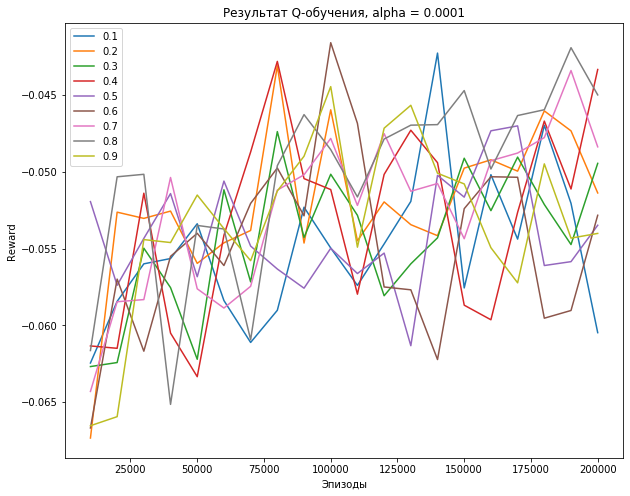

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(epsilons, results_with_different_params)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения, alpha = {alpha}')

Лучшие параметры alpha = 0.4 и alpha = 0.8. Подберем epsilon:

In [6]:
from itertools import product
epsilons = [0.4, 0.8]
alphas = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
params = product(epsilons, alphas)

In [7]:
k=10_000

results_with_different_alphas = []
total_episodes = 200000
for p in params:
    print(f'Alpha: {p[1]} Epsilon: {p[0]}')
    learner = BlackJack_Q_Learner(can_double=False)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=p[1], epsilon=p[0],
                                                     print_every_k_episodes=k)
    results_with_different_alphas.append((mean_rewards, l_bounds, u_bounds))

Alpha: 1e-05 Epsilon: 0.4
Conducting experiment after 10000 episodes: -0.0645525
Conducting experiment after 20000 episodes: -0.060815
Conducting experiment after 30000 episodes: -0.0529175
Conducting experiment after 40000 episodes: -0.05713
Conducting experiment after 50000 episodes: -0.05313
Conducting experiment after 60000 episodes: -0.0536325
Conducting experiment after 70000 episodes: -0.055785
Conducting experiment after 80000 episodes: -0.05732
Conducting experiment after 90000 episodes: -0.0566225
Conducting experiment after 100000 episodes: -0.0534625
Conducting experiment after 110000 episodes: -0.061045
Conducting experiment after 120000 episodes: -0.0558125
Conducting experiment after 130000 episodes: -0.051985
Conducting experiment after 140000 episodes: -0.05125
Conducting experiment after 150000 episodes: -0.049205
Conducting experiment after 160000 episodes: -0.0445275
Conducting experiment after 170000 episodes: -0.0475525
Conducting experiment after 180000 episodes:

Conducting experiment after 70000 episodes: -0.050375
Conducting experiment after 80000 episodes: -0.058635
Conducting experiment after 90000 episodes: -0.0527425
Conducting experiment after 100000 episodes: -0.054965
Conducting experiment after 110000 episodes: -0.05685
Conducting experiment after 120000 episodes: -0.048665
Conducting experiment after 130000 episodes: -0.04912
Conducting experiment after 140000 episodes: -0.0519525
Conducting experiment after 150000 episodes: -0.05766
Conducting experiment after 160000 episodes: -0.0525475
Conducting experiment after 170000 episodes: -0.05138
Conducting experiment after 180000 episodes: -0.04673
Conducting experiment after 190000 episodes: -0.04683
Conducting experiment after 200000 episodes: -0.0465925
Alpha: 0.0003 Epsilon: 0.8
Conducting experiment after 10000 episodes: -0.0607325
Conducting experiment after 20000 episodes: -0.0543075
Conducting experiment after 30000 episodes: -0.0494425
Conducting experiment after 40000 episodes:

Text(0.5, 1.0, 'Результат Q-обучения (подбор epsilon)')

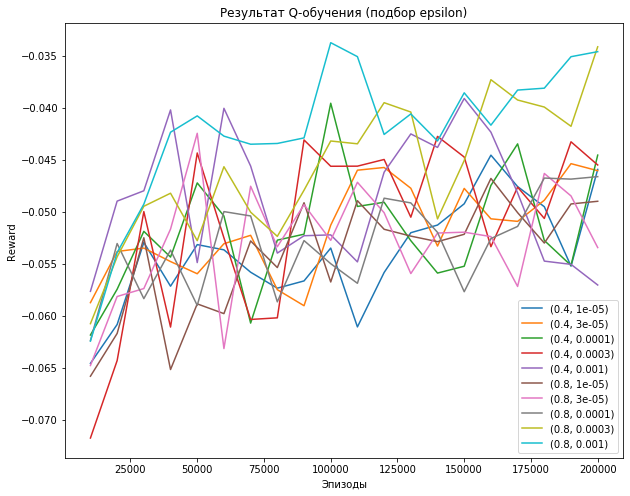

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(product(epsilons, alphas), results_with_different_alphas)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения (подбор epsilon)')

Самые лучшие значения alpha 1e-3, при epsilon 0.8 уточним параметры:

In [13]:
alpha = 1e-3
k=10_000
epsilons = [0.75, 0.8, 0.85]

results_with_different_params = []
total_episodes = 200000
for eps in epsilons:
    print(f'Epsilon: {eps}')
    learner = BlackJack_Q_Learner(can_double=False)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=alpha, epsilon=eps,
                                                     print_every_k_episodes=k)
    results_with_different_params.append((mean_rewards, l_bounds, u_bounds))

Epsilon: 0.75
Conducting experiment after 10000 episodes: -0.0659
Conducting experiment after 20000 episodes: -0.0549575
Conducting experiment after 30000 episodes: -0.0518625
Conducting experiment after 40000 episodes: -0.0501225
Conducting experiment after 50000 episodes: -0.0453375
Conducting experiment after 60000 episodes: -0.047385
Conducting experiment after 70000 episodes: -0.0430175
Conducting experiment after 80000 episodes: -0.0396725
Conducting experiment after 90000 episodes: -0.03511
Conducting experiment after 100000 episodes: -0.038595
Conducting experiment after 110000 episodes: -0.036415
Conducting experiment after 120000 episodes: -0.04484
Conducting experiment after 130000 episodes: -0.0403125
Conducting experiment after 140000 episodes: -0.0393275
Conducting experiment after 150000 episodes: -0.0387175
Conducting experiment after 160000 episodes: -0.0415175
Conducting experiment after 170000 episodes: -0.0363325
Conducting experiment after 180000 episodes: -0.03492

Text(0.5, 1.0, 'Результат Q-обучения, alpha = 0.0001')

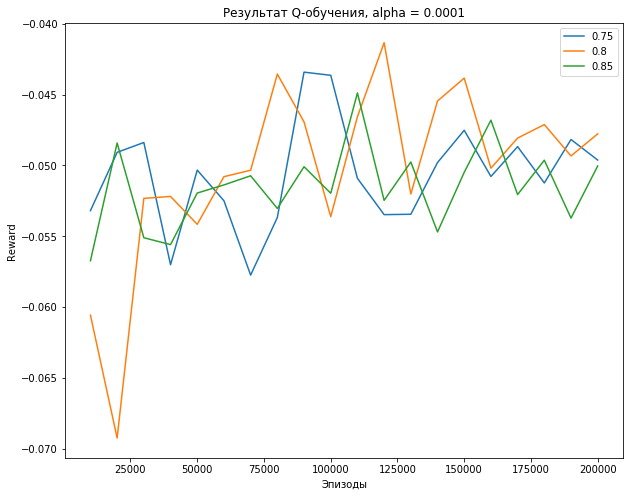

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(epsilons, results_with_different_params)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения, alpha = {alpha}')

Лучший результат получился при параметрах: alpha=1e-3, epsilon=0.8 (видимо на таком количестве эпизодов важнее сильный exploration)

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4) Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

5) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [24]:
n_episodes = 300_000
n_experiments = 200_000
learner = BlackJack_Q_Learner(can_double=True)
learner.learn(n_episodes=n_episodes, alpha=1e-3, epsilon=0.8)
print("Learning complete!")
rewards = learner.conduct_experiment(n_experiments=n_experiments)
result, lower, upper = compute_confidence_interval(rewards)
print(f'Средний проигрыш при такой стратегии за {n_experiments} экспериментов: {result},\n\
Доверительный интервал (95%): ({lower:0.4f}:{upper:0.4f})')

Learning complete!
Средний проигрыш при такой стратегии за 200000 экспериментов: -0.0382025,
Доверительный интервал (95%): (-0.0434:-0.0330)


#### Результат немного улучшился

In [27]:
alpha = 1e-4
k=20_000
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results_with_different_params = []
total_episodes = 300000
for eps in epsilons:
    print(f'Epsilon: {eps}')
    learner = BlackJack_Q_Learner(can_double=True)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=alpha, epsilon=eps,
                                                     print_every_k_episodes=k)
    results_with_different_params.append((mean_rewards, l_bounds, u_bounds))

Epsilon: 0.1
Conducting experiment after 20000 episodes: -0.1417625
Conducting experiment after 40000 episodes: -0.116355
Conducting experiment after 60000 episodes: -0.2012475
Conducting experiment after 80000 episodes: -0.1067125
Conducting experiment after 100000 episodes: -0.0939125
Conducting experiment after 120000 episodes: -0.1132875
Conducting experiment after 140000 episodes: -0.0934
Conducting experiment after 160000 episodes: -0.11718
Conducting experiment after 180000 episodes: -0.10218
Conducting experiment after 200000 episodes: -0.1029175
Conducting experiment after 220000 episodes: -0.119025
Conducting experiment after 240000 episodes: -0.10519
Conducting experiment after 260000 episodes: -0.1005875
Conducting experiment after 280000 episodes: -0.130315
Conducting experiment after 300000 episodes: -0.08895
Epsilon: 0.2
Conducting experiment after 20000 episodes: -0.1447675
Conducting experiment after 40000 episodes: -0.1099525
Conducting experiment after 60000 episodes

Text(0.5, 1.0, 'Результат Q-обучения, alpha = 0.0001')

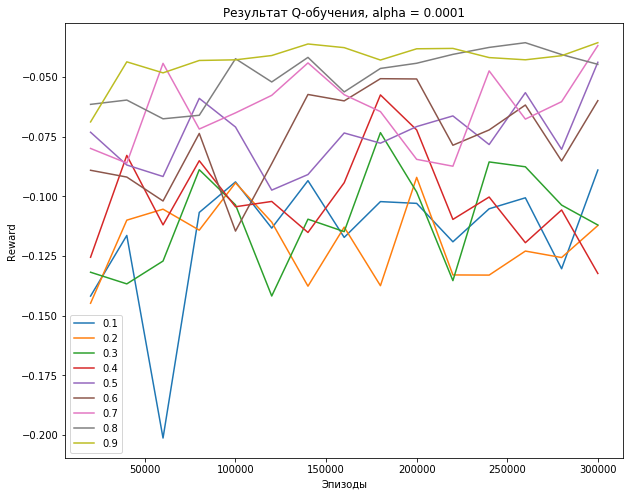

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(epsilons, results_with_different_params)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения, alpha = {alpha}')

Количество состояний стало больше и еще заметнее то, что для высоких epsilon обучение проходит лучше. Для epsilon от 0.5 и меньше стратегия толком не обучается. Проверим разные alpha для больших epsilon. 

In [30]:
from itertools import product
epsilons = [0.7, 0.8, 0.9]
alphas = [1e-4, 3e-4, 1e-3]
params = product(epsilons, alphas)

k=20_000

results_with_different_alphas = []
total_episodes = 300_000
for p in params:
    print(f'Alpha: {p[1]} Epsilon: {p[0]}')
    learner = BlackJack_Q_Learner(can_double=True)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=p[1], epsilon=p[0],
                                                     print_every_k_episodes=k)
    results_with_different_alphas.append((mean_rewards, l_bounds, u_bounds))

Alpha: 0.0001 Epsilon: 0.7
Conducting experiment after 20000 episodes: -0.0679675
Conducting experiment after 40000 episodes: -0.076355
Conducting experiment after 60000 episodes: -0.0597125
Conducting experiment after 80000 episodes: -0.07311
Conducting experiment after 100000 episodes: -0.0707425
Conducting experiment after 120000 episodes: -0.0443175
Conducting experiment after 140000 episodes: -0.0449475
Conducting experiment after 160000 episodes: -0.04868
Conducting experiment after 180000 episodes: -0.05275
Conducting experiment after 200000 episodes: -0.061055
Conducting experiment after 220000 episodes: -0.0414125
Conducting experiment after 240000 episodes: -0.0557525
Conducting experiment after 260000 episodes: -0.0781
Conducting experiment after 280000 episodes: -0.0689925
Conducting experiment after 300000 episodes: -0.04358
Alpha: 0.0003 Epsilon: 0.7
Conducting experiment after 20000 episodes: -0.072365
Conducting experiment after 40000 episodes: -0.0773675
Conducting exp

Text(0.5, 1.0, 'Результат Q-обучения (подбор epsilon)')

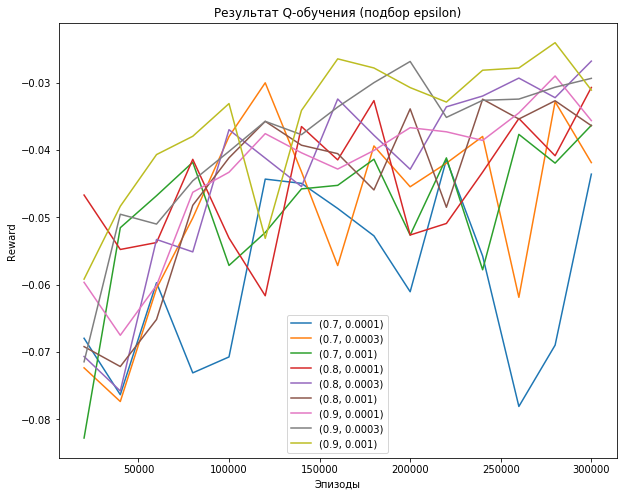

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(product(epsilons, alphas), results_with_different_alphas)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения (подбор epsilon)')

Уточним параметры:

In [32]:
from itertools import product
epsilons = [0.75, 0.8, 0.85]
alphas = [3e-4]
params = product(epsilons, alphas)

k=20_000

results_with_different_alphas = []
total_episodes = 300_000
for p in params:
    print(f'Alpha: {p[1]} Epsilon: {p[0]}')
    learner = BlackJack_Q_Learner(can_double=True)
    mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                     alpha=p[1], epsilon=p[0],
                                                     print_every_k_episodes=k)
    results_with_different_alphas.append((mean_rewards, l_bounds, u_bounds))

Alpha: 0.0003 Epsilon: 0.75
Conducting experiment after 20000 episodes: -0.0681375
Conducting experiment after 40000 episodes: -0.0827825
Conducting experiment after 60000 episodes: -0.05303
Conducting experiment after 80000 episodes: -0.0354025
Conducting experiment after 100000 episodes: -0.0625425
Conducting experiment after 120000 episodes: -0.066035
Conducting experiment after 140000 episodes: -0.049335
Conducting experiment after 160000 episodes: -0.0437525
Conducting experiment after 180000 episodes: -0.04198
Conducting experiment after 200000 episodes: -0.0393075
Conducting experiment after 220000 episodes: -0.0450775
Conducting experiment after 240000 episodes: -0.035035
Conducting experiment after 260000 episodes: -0.0616975
Conducting experiment after 280000 episodes: -0.031845
Conducting experiment after 300000 episodes: -0.044345
Alpha: 0.0003 Epsilon: 0.8
Conducting experiment after 20000 episodes: -0.069785
Conducting experiment after 40000 episodes: -0.0505025
Conductin

Text(0.5, 1.0, 'Результат Q-обучения (подбор epsilon)')

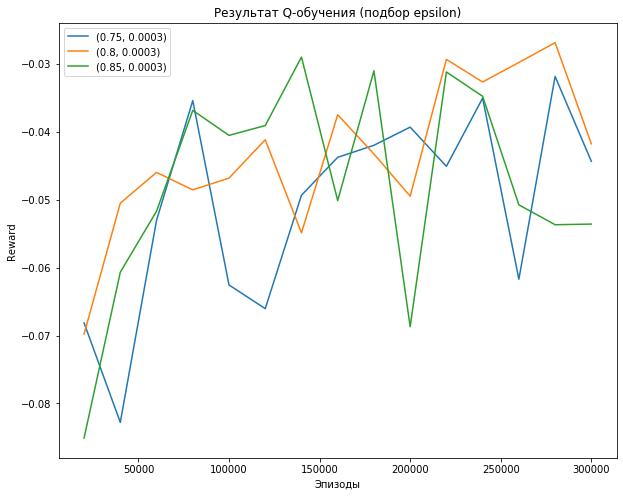

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lines = []
for i, (p, result) in enumerate(zip(product(epsilons, alphas), results_with_different_alphas)):
    ax.plot(np.arange(k, total_episodes+1, k), result[0], label=f"{p}", color=f"C{i}")

ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.legend()
plt.title(f'Результат Q-обучения (подбор epsilon)')

Лучшая стратегия обучилась при alpha = 3e-4, epsilon = 0.8. В разных экспериментах от -0.042 до -0.026

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6) Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

7) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



In [194]:
'''Реализуем метод с подсчетом карт по методу «Плюс-минус»
2, 3, 4, 5, 6: +1
7, 8, 9: 0
10, В, Д, К, Т: -1
'''

from gym import spaces
from gym.utils import seeding
from gym.envs.toy_text.blackjack import BlackjackEnv
import random

class BlackjackCardCountingEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)  # Now we have 3 actions instead of 2 (stick=0, hit=1, double=2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21))),
        self.seed()
        
        self.dealer = []
        self.player = []
        
        # Создаем и перемешиваем колоду
        self.get_new_deck()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.get_deck_status())
    
    def get_deck_status(self):
        ''' вообще статус колоды может быть от -20 до +20, но мы оставим только 21 состояний.
        Все что больше по модулю 10 - будем клипать до модуля 10)
        '''
        status = self.current_deck
        if status < -10:
            status = -10
        elif status > 10:
            status = 10
        return status + 10

    def get_new_deck(self):
        ''' Берем новую колоду и перемышиваем.
        При этом обнуляем также наш запомненный статус колоды
        '''
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)
        self.current_deck = 0
        # Нам нужно запомнить какие карты дилера нам не нужно считать (все, которые были из предыдущей колоды)
        self.not_relevant_dealer_cards = len(self.dealer)
    
    def start_new_game(self):
        ''' Начинаем новую игру (колода прежняя)
        '''
        # Сдаем карты дилеру
        self.dealer = []
        self.dealer.append(self.get_card())
        self.dealer.append(self.get_card(visible=False))
        self.not_relevant_dealer_cards = 1
        # Сдаем карты игроку
        self.player = []
        self.player.append(self.get_card())
        self.player.append(self.get_card())
        return self._get_obs()
    
    def get_card(self, visible=True):
        ''' Берем карту из колоды и считаем ее
        (если игрок видит эту карту)
        При необходимости берем новую колоду
        '''
        card = self.deck.pop()
        if visible:
            self.current_deck += get_card_value(card)
        if len(self.deck) < 15:
            ''' Если осталось меньше 15 кард - берем новую колоду
            '''
            self.get_new_deck()
        return card
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add only one card, reward/loss is double.
            done = True
            self.player.append(self.get_card())
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.get_card(visible=False)) # Считаем для удобства, что дилер берет в закрытую
                reward = 2.0 * cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 3.
            
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(self.get_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.get_card(visible=False)) # Считаем для удобства, что дилер берет в закрытую
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        if done: # Закончили эпизод и увидели карты дилеры - их нужно посчитать:
            for card in self.dealer[self.not_relevant_dealer_cards:]:
                self.current_deck += get_card_value(card)
        return self._get_obs(), reward, done, {}

def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def get_card_value(card): # Определяем как считать эту карту
    if card in [2, 3, 4, 5, 6]:
        return 1
    elif card in [1, 10]:
        return  -1
    return 0

In [195]:
# Q-Learner для стандартного env и с удвоением

class BlackJackCardCounting_Q_Learner(BlackJack_Q_Learner):
    def __init__(self, natural=True):
        self._ph = 32 # player_hand
        self._dh = 11 # dealer hand
        self._ua = 2 # usable ace
        self._ds = 21 # статус колоды (deck status)
        self._nA = 3 # actions number
        self._nS = self._ph * self._dh * self._ua * self._ds # nS
        self._env = BlackjackCardCountingEnv(natural=natural)
        self._env.reset()
    
    def _observation_to_idx(self, s):
        return (s[0] - 1) * self._dh * self._ua * self._ds + (s[1] - 1) * self._ua * self._ds + s[2] * self._ds + s[3]
    
    def idx_to_observation(self, idx):
        s_3 = int(idx % self._ds)
        idx = (idx - s_3) / self._ds
        s_2 = bool(idx % self._ua)
        idx = (idx - s_2) / self._ua
        s_1 = int(idx % self._dh + 1)
        s_0 = int((idx - (s_1 - 1)) / self._dh + 1)
        return (s_0, s_1, s_2, s_3)
    
    def _Q_learning_episode(self, alpha, epsilon, gamma):
        obs = self._env.start_new_game()
        s = self._observation_to_idx(obs)
        pi = self.get_current_policy()
        if np.random.rand() > epsilon:
            a = pi[s]
        else:
            a = np.random.randint(self._nA)
        done = False
        while not done:
            pi = self.get_current_policy()
            observation, reward, done, _ = self._env.step(a)
            s_prime = self._observation_to_idx(observation)
            if np.random.rand() > epsilon:
                a_prime = pi[s_prime]
            else:
                a_prime = np.random.randint(self._nA)
            self._Q[s, a] = self._Q[s, a] + alpha * (reward + gamma * np.max(self._Q[s_prime]) - self._Q[s, a])
            s = s_prime
            if done:
                break
        
    def conduct_experiment(self, pi=None, n_experiments=200_000):
        if not pi:
            pi = self.pi
        rewards = []
        for _ in range(n_experiments):
            observation = self._env.start_new_game()
            s = self._observation_to_idx(observation)
            done = False
            reward = 0
            while not done:
                a = pi[s]
                observation, reward, done, _ = self._env.step(a)
                s = self._observation_to_idx(observation)
            rewards.append(reward)
        return rewards

In [198]:
total_episodes = 5_000_000
k = 200_000
alpha=3e-4
epsilon=0.8

learner = BlackJackCardCounting_Q_Learner()
mean_rewards, l_bounds, u_bounds = learner.learn(n_episodes=total_episodes,
                                                 alpha=alpha, epsilon=epsilon,
                                                 print_every_k_episodes=k)
print("Learning complete!")

Conducting experiment after 200000 episodes: -0.0762325
Conducting experiment after 400000 episodes: -0.0477375
Conducting experiment after 600000 episodes: -0.057705
Conducting experiment after 800000 episodes: -0.0381125
Conducting experiment after 1000000 episodes: -0.04307
Conducting experiment after 1200000 episodes: -0.0386675
Conducting experiment after 1400000 episodes: -0.0395725
Conducting experiment after 1600000 episodes: -0.038655
Conducting experiment after 1800000 episodes: -0.03724
Conducting experiment after 2000000 episodes: -0.0356625
Conducting experiment after 2200000 episodes: -0.03418
Conducting experiment after 2400000 episodes: -0.0340975
Conducting experiment after 2600000 episodes: -0.0345425
Conducting experiment after 2800000 episodes: -0.025815
Conducting experiment after 3000000 episodes: -0.0338175
Conducting experiment after 3200000 episodes: -0.028495
Conducting experiment after 3400000 episodes: -0.0331375
Conducting experiment after 3600000 episodes:

Text(0.5, 1.0, 'Результат Q-обучения с подсчетом карт')

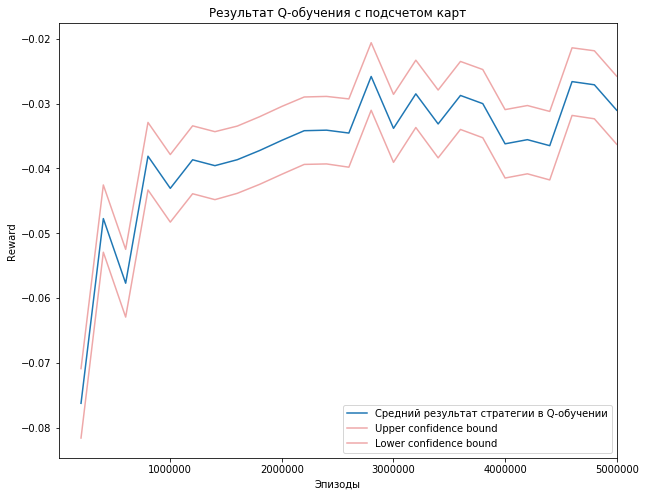

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

line_rewards = ax.plot(np.arange(k, total_episodes+1, k), mean_rewards, label="Средний результат стратегии в Q-обучении", color="C0")
line_upper = ax.plot(np.arange(k, total_episodes+1, k), u_bounds, label="Upper confidence bound", color="C3", alpha=0.4)
line_lower = ax.plot(np.arange(k, total_episodes+1, k), l_bounds, label="Lower confidence bound", color="C3", alpha=0.4)

lines = line_rewards + line_upper + line_lower
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc="lower right")
ax.set_xlim((1, total_episodes))
ax.set_xlabel("Эпизоды")
ax.set_ylabel("Reward")
plt.title('Результат Q-обучения с подсчетом карт')

#### Видим что такой вид подсчета с одной стороны стратегия получается немного лучше, но с другой стороны требует на порядок больше эпизодо для обучения (что логично, так как у нас стало в 20 раз больше состояний)